# Influenza Enet Predictions
- Predicting dominant strains using Emergenet

In [73]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import trange
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

## Downloading Data
**Sources: [GISAID](https://platform.epicov.org/epi3/cfrontend#586f5f) and [NCBI](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Protein&HostLineage_ss=Homo%20sapiens%20(human),%20taxid:9606&LabHost_s=include&ProtNames_ss=hemagglutinin&CollectionDate_dr=2003-11-01T00:00:00.00Z%20TO%202004-05-01T23:59:59.00Z&SLen_i=550%20TO%20566&VirusLineage_ss=H1N1%20subtype,%20taxid:114727)**

- Data collected from NCBI and GISAID in `dominant_sequences.ipynb`
- Merged NCBI and GISAID data found in `raw_data/merged/`

## Create Enet Models
- Truncate HA at 565 amino acids, we only need HA models
- Give enet the same name as the data file
    
### Running Processes

Computations are done in:
- `enet_train.py`
- `run_enet_train.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_enet_train.sh
./run_enet_train.sh`

## Predictions
E-Centroid: $$x_{*}^{t+\delta} = argmin_{y\in \bigcup_{r\leq t}H^{\tau}} \sum_{x \in {H^t}} \theta(x,y) - |H^t|A \text{ln}\omega_y$$
- $x_{*}^{t+\delta}$ is the dominant strain in the upcoming flu season at time $t+\omega$
- $H^t$ is the sequence population at time $t$
- $\theta(x,y)$ is the e-distance between $x$ and $y$ in their respective Enets
- $A = \frac{1-\alpha}{\sqrt{8}N^2}$, where $\alpha$ is a fixed significance level and $N$ is the sequence length considered
- $\text{ln}\omega_y$ is the membership degree of sequence $y$
- Predict dominant strain based on HA data only
- Run 3 cluster predictions (i.e. 3 strains per season) and take the top 2

### Running Processes

Computations are done in:
- `enet_predictions.py`
- `run_enet_predictions.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_enet_predictions.sh
./run_enet_predictions.sh`

### Predict on Complete Strains
- Both HA and NA sequence available
    - Found in `raw_data/merged/<HEMISPHERE_SUBTYPE>/`
    - These record HA sequence data only for the purpose of prediction, the NA data will be retreived after running predictions

In [69]:
PRED_DIR = 'results/enet_predictions/seasonal_predictions/'
DATA_DIR = 'raw_data/merged/'
DM_DIR = 'results/enet_predictions/distance_matrices/'
FILES = ['north_h1n1', 'north_h3n2', 'south_h1n1', 'south_h3n2']

NORTH_YEARS = []
for i in np.arange(1, 23):
    YEAR = ''
    if i < 10:
        YEAR += '0' + str(i)
    else:
        YEAR += (str(i))
    if i + 1 < 10:
        YEAR += '_0' + str(i + 1)
    else:
        YEAR += '_' + str(i + 1)
    NORTH_YEARS.append(YEAR)
        
SOUTH_YEARS = []
for i in np.arange(2, 24):
    if i < 10:
        SOUTH_YEARS.append('0' + str(i))
    else:
        SOUTH_YEARS.append(str(i))

In [47]:
for FILE in FILES: 
    YEARS = []
    if FILE[:5] == 'north':
        YEARS = NORTH_YEARS
    else:
        YEARS = SOUTH_YEARS
    for i in range(21):
        ha_df = pd.read_csv(DATA_DIR + FILE + '_ha/' + FILE + '_ha_' + YEARS[i] + '.csv')
        na_df = pd.read_csv(DATA_DIR + FILE + '_na/' + FILE + '_na_' + YEARS[i] + '.csv')
        # keep only HA sequences which also have an NA sequence
        ha_df = ha_df[ha_df['name'].isin(na_df['name'])]
        ha_df.to_csv(DATA_DIR + FILE + '/' + FILE + '_ha_' + YEARS[i] + '.csv', index = False)

## Aggregate Predictions

In [72]:
for FILE in FILES:
    pred_df = pd.DataFrame(columns=['season',
                                    'name_0','cluster_size_0','ha_acc_0','ha_seq_0','na_acc_0','na_seq_0',
                                    'name_1','cluster_size_1','ha_acc_1','ha_seq_1','na_acc_1','na_seq_1',
                                    'name_2','cluster_size_2','ha_acc_2','ha_seq_2','na_acc_2','na_seq_2']) 
    YEARS = []
    if FILE[:5] == 'north':
        YEARS = NORTH_YEARS
    else:
        YEARS = SOUTH_YEARS
    for i in range(21):
        df = pd.read_csv(PRED_DIR + FILE + '_ha/' + FILE + '_ha_' + YEARS[i + 1] + '_predictions.csv')
        na_df = pd.read_csv(DATA_DIR + FILE + '_na/' + FILE + '_na_' + YEARS[i] + '.csv')
        
        # expand to larger dataframe, get NA sequence
        df1 = pd.DataFrame({'season':[df['season'][0]]})
        for j in range(3):
            na_seq_df = na_df[na_df['name'] == df['name'].values[j]]
            df1['name_'+str(j)] = df['name'].values[j]
            df1['cluster_size_'+str(j)] = df['cluster_size'].values[j]
            df1['ha_acc_'+str(j)] = df['acc'].values[j]
            df1['ha_seq_'+str(j)] = df['sequence'].values[j]
            df1['na_acc_'+str(j)] = na_seq_df['acc'].values[0]
            df1['na_seq_'+str(j)] = na_seq_df['sequence'].values[0]
            
        # append to pred_df
        pred_df = pd.concat([pred_df, df1])
        
    # Enet recommendation accession, name, sequence
    pred_df.to_csv('results/enet_predictions/' + FILE + '_predictions.csv', index=False)

## Strain Clusters Per Season
- Show cluster sizes when clustering 2-5
- Use precomputed distance matrices from `enet_predictions/distance_matrices`

In [70]:
# find cluster sizes for n_clusters
def cluster_proportions(dm_path, n_clusters):
    # load qdistance matrix
    dm = pd.read_csv(dm_path, index_col=0)
    # convert distance matrix to embedding
    embedding = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    dm_embed = embedding.fit_transform(dm)
    # cluster the distance matrix
    clustering = KMeans(n_clusters=n_clusters, random_state=42)
    clustering_predictions = clustering.fit_predict(dm_embed)
    # find unique clusters
    unique_clusters = np.unique(clustering_predictions)
    # cluster_sizes
    cluster_sizes = []
    for class_ in unique_clusters:
        # separate distance matrix into submatrices
        wanted_names = dm.columns[clustering_predictions == class_]
        cluster_sizes.append(len(wanted_names))
    cluster_sizes = sorted(cluster_sizes, reverse=True)
    cluster_props = [sum(cluster_sizes[:min(len(cluster_sizes),i)])/sum(cluster_sizes) for i in range(1, 4)]
    return np.array(cluster_props)

In [71]:
average_cluster_props = []

for n in trange(2, 7):
    total_cluster_props = np.zeros(3)
    for FILE in FILES:  
        YEARS = NORTH_YEARS[:21]
        if FILE[:5] == 'south':
            YEARS = SOUTH_YEARS[:21]
        for YEAR in YEARS:
            NAME = FILE + '_ha_' + YEAR
            DM_PATH = DM_DIR + FILE + '_ha/' + NAME + '.csv'
            total_cluster_props += cluster_proportions(DM_PATH, n)
    average_cluster_props.append(total_cluster_props/(4*len(YEARS)))

average_cluster_props

  0%|          | 0/5 [00:00<?, ?it/s]

[array([0.83419743, 1.        , 1.        ]),
 array([0.76141603, 0.94667045, 1.        ]),
 array([0.68628611, 0.90481623, 0.97124001]),
 array([0.64447742, 0.85947326, 0.94842269]),
 array([0.61078351, 0.82732978, 0.91823212])]

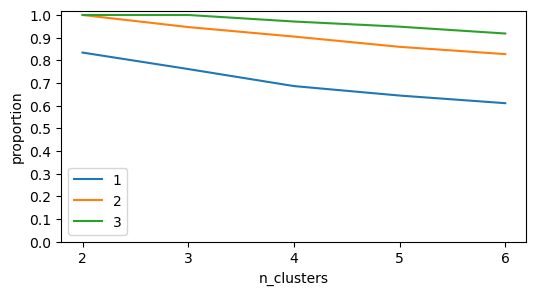

In [111]:
x = np.arange(2, 7)
y = np.array(average_cluster_props).T

plt.figure(figsize=(6, 3))
plt.plot(x,y[0], label = '1')
plt.plot(x,y[1], label = '2')
plt.plot(x,y[2], label = '3')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('n_clusters')
plt.ylabel('proportion')
plt.legend();